In [61]:
from quspin.operators import hamiltonian, quantum_operator # Hamiltonians and operators
from quspin.basis import spin_basis_1d, spin_basis_general # Hilbert space spin basis
from quspin.tools.measurements import diag_ensemble
import numpy as np # generic math functions
import matplotlib.pyplot as plt
%matplotlib inline

from quspin.tools.measurements import ED_state_vs_time

import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 30,
})

from scipy.integrate import simps
import itertools
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar, bisect, shgo

import pandas as pd
import seaborn as sns
from scipy.optimize import lsq_linear

Exact cover 3 (EC3) Hamiltonian

$\hat{H}_\text{EC3}=J\sum_{(i,j,k)\in C} (\hat{\sigma}^z_i+\hat{\sigma}^z_j+\hat{\sigma}^z_j-1)^2$

where $C$ contains $M$ triples with randomly chosen $i,j,k=[1,...,N]$ and $i\neq j\neq k$

$(\hat{\sigma}^z_i+\hat{\sigma}^z_j+\hat{\sigma}^z_j-1)^2 = \sum_{l=i,j,k}\sum_{m=i,j,k}\hat{\sigma}^z_l\hat{\sigma}^z_m-2\sum_{l=i,j,k}\hat{\sigma}^z_l$ + 1

In [2]:
def EC3_hamiltonian(basis,M):
    X = 3
    N = basis.N
    
    J_zz, J_z, offset = [], [], []
    for l in range(M):
        triple = np.random.choice(np.arange(N),size=X,replace=False)
        for m in itertools.product(triple,triple):
            J_zz += [[1,m[0],m[1]]]
        for m in range(X):
            J_z += [[-2,triple[m]]]
        offset += [[1,l]]
    
    return hamiltonian([["zz",J_zz],["z",J_z],["I",offset]],[],basis=basis,dtype=np.float64,check_symm=False, check_herm=False)


In [3]:
def check_USA(H1):
    Es = np.sort(H1.toarray().diagonal())
    if int(Es[0]) == 0 and Es[1] > 0:
        return True
    else:
        return False
    

In [4]:
def USA_hamiltonian(basis):
    is_USA = False
    while not is_USA:
        H = EC3_hamiltonian(basis,M=basis.N-1)
        is_USA = check_USA(H)
    return H

Observable:

$\hat{\sigma}^z=\sum_{i=1}^N\hat{\sigma}^z_i\langle GS|\hat{\sigma}^z_i|GS\rangle$

where $\hat{H}_\text{EC3}|GS\rangle=E_0|GS\rangle$

In [5]:
def GS_observable(basis,GS):
    expt_O = np.zeros(basis.N)
    for i in range(basis.N):
        O = hamiltonian([["z",[[1,i]]]],[],basis=basis,dtype=np.float64,check_symm=False, check_herm=False)
        expt_O[i] = O.expt_value(GS)
    x_obs=[[expt_O[i]/basis.N,i] for i in range(basis.N)]

    static_obs = [["z",x_obs]]

    return hamiltonian(static_obs,[],basis=basis,dtype=np.float64,check_symm=False, check_herm=False)

In [6]:
def x_observable(basis):
    x_obs=[[1./basis.N,i] for i in range(basis.N)]

    static_obs = [["x",x_obs]]

    return hamiltonian(static_obs,[],basis=basis,dtype=np.float64,check_symm=False, check_herm=False)

Initial state is $x$ polarized state corresponding to the largest eigenvalue eigenstate of $\sigma^x$

$|\psi(0)\rangle = |\rightarrow\rightarrow...\rightarrow\rangle$

Quench Hamiltonian with transverse field

$\hat{H}(h)=(1-h)\hat{H}_p+h\hat{H}_p$

with $\hat{H}_p =\hat{H}_\mathrm{EC3}$ and $\hat{H}_p =\sum_{i=1}^N\hat{\sigma}^x_i$

Normalized annealing gap

$\Delta(h)=\frac{E_2(h)-E_1(h)}{W(h)}$ where $W(h)=E_{2^N}(h)-E_1(h)$ is the bandwidth and $E_n(h)$ is the $n$th eigenvalue of $\hat{H}(h)$.

In [7]:
def gap(basis,H1,h):
    N = basis.N
    #quench hamiltonian
    x_field=[[-h,i] for i in range(N)]
    static=[(1-h)*H1.static,["x",x_field]]
    H2 =  hamiltonian(static,[],basis=basis,dtype=np.float64,check_symm=False, check_herm=False)
    E2,V2=H2.eigh()
    
    return (E2[1]-E2[0])/(E2[-1]-E2[0])


In [8]:
def gap_sparse(basis,H1,h):
    N = basis.N
    #quench hamiltonian
    x_field=[[-h,i] for i in range(N)]
    static=[(1-h)*H1.static,["x",x_field]]
    H2 =  hamiltonian(static,[],basis=basis,dtype=np.float64,check_symm=False, check_herm=False)
    E2=H2.eigsh(k=2,which='SA',return_eigenvectors=False)[::-1]
    E3=H2.eigsh(k=1,which='LA',return_eigenvectors=False)[0]
    
    return (E2[1]-E2[0])/(E3-E2[0])


In [110]:
def gapJ(basis,H1,h):
    N = basis.N
    #quench hamiltonian
    x_field=[[-h,i] for i in range(N)]
    static=[(1-h)*H1.static,["x",x_field]]
    H2 =  hamiltonian(static,[],basis=basis,dtype=np.float64,check_symm=False, check_herm=False)
    E2,V2=H2.eigh()
    
    return (E2[1]-E2[0])


In [10]:
def gap_sparseJ(basis,H1,h):
    N = basis.N
    #quench hamiltonian
    x_field=[[-h,i] for i in range(N)]
    static=[(1-h)*H1.static,["x",x_field]]
    H2 =  hamiltonian(static,[],basis=basis,dtype=np.float64,check_symm=False, check_herm=False)
    E2=H2.eigsh(k=2,which='SA',return_eigenvectors=False)[::-1]
    E3=H2.eigsh(k=1,which='LA',return_eigenvectors=False)[0]
    
    return (E2[1]-E2[0])


annealing protocols: linear and two quadratic functions for $h(t)$

In [11]:
def time_dependent_Hamiltonian(basis,H1,h_i,b_i):
    N = basis.N
    def A(t,h,b):
        return 1 - h  - b*t
    def B(t,h,b):
        return h + b*t
    linear_args = [h_i,b_i]
    H_p = H1.static
    H_q = [[-1,i] for i in range(N)]
    dynamic = [[H_p,A,linear_args],["x",H_q,B,linear_args]]
    H2 =  hamiltonian([],dynamic,basis=basis,dtype=np.float64,check_symm=False, check_herm=False)
    
    return H2

In [12]:
def lin_anneal(basis,H,T,N_steps,plot=True):
    Hlin = time_dependent_Hamiltonian(basis,H,1,-1./T)
    Elin, Vlin = Hlin.eigh(time=0)
    psi0 = Vlin[:,0]
    
    
    timeslin = np.linspace(0,T,N_steps)
    time_evolvedlin = Hlin.evolve(psi0,0,timeslin)
    
    if plot:
        plt.plot(timeslin,1-1./T*timeslin)
        plt.xlabel('$t$')
        plt.ylabel('$h(t)$')
    
    instantaneouslin = np.zeros((2**basis.N,N_steps),complex)
    for i, t in enumerate(timeslin):
        instantaneouslin[:,i] = Hlin.eigh(t)[1][:,0]
        
    return timeslin,abs(np.dot(time_evolvedlin.T.conj(),instantaneouslin)).diagonal()

In [13]:
def quadraticRamp_Hamiltonian(basis,H1,a,b,c):
    N = basis.N
    def A(t,a,b,c):
        return 1 - (a + b*t + c*t**2)
    def B(t,a,b,c):
        return a + b*t + c*t**2
    ramp_args = [a,b,c]
    H_p = H1.static
    H_q = [[-1,i] for i in range(N)]
    dynamic = [[H_p,A,ramp_args],["x",H_q,B,ramp_args]]
    H2 =  hamiltonian([],dynamic,basis=basis,dtype=np.float64,check_symm=False, check_herm=False)
    
    return H2

In [14]:
def quadraticRamp_evo_minGap(basis,H,hc,vc,T,N_steps,plot=True):
    
    times = np.linspace(0,T,N_steps)
    tc = T*(1-hc)
    
    c1 = vc/tc + (1-hc)/tc**2
    b1 = vc - 2*c1*tc
    a1 = 1
    
    times1 = times[times<=tc]
    h1 = 1 + b1*times1 + c1*times1**2
    
    c2 = vc/(tc-T) - hc/(tc-T)**2
    b2 = vc - 2*c2*tc
    a2 = -b2*T - c2*T**2

    times2 = times[times>tc]
    h2 = b2*(times2 - T) + c2*(times2**2 - T**2)
    
    if plot:
        plt.plot(times1,h1)
        plt.plot(times2,h2)
        plt.xlabel('$t$')
        plt.ylabel('$h(t)$')
    
    H1 = quadraticRamp_Hamiltonian(basis,H,a1,b1,c1)
    EH, VH, = H1.eigh(time=0)
    psi0 = VH[:,0]
    time_evolved1 = H1.evolve(psi0,0,times1)
    instantaneous1 = np.zeros((2**basis.N,len(times1)),complex)
    for i, t in enumerate(times1):
        instantaneous1[:,i] = H1.eigh(t)[1][:,0]
    overlap1 = abs(np.dot(time_evolved1.T.conj(),instantaneous1)).diagonal()

    
    H2 = quadraticRamp_Hamiltonian(basis,H,a2,b2,c2)
    psi1 = time_evolved1[:,-1]
    time_evolved2 = H2.evolve(psi1,tc,times2)
    instantaneous2 = np.zeros((2**basis.N,len(times2)),complex)
    for i, t in enumerate(times2):
        instantaneous2[:,i] = H2.eigh(t)[1][:,0]
    overlap2 = abs(np.dot(time_evolved2.T.conj(),instantaneous2)).diagonal()
    
    return times, np.append(overlap1,overlap2)

dynamical quantum phase transition order parameter

In [15]:
def evo(basis,H1,h,times,observable):
    assert observable == 'x' or observable == 'GS'
    N = basis.N
    if observable == 'GS':
        E1,V1 = H1.eigh()
        GS = V1[:,0]
        #GS observable
        Obs = GS_observable(basis,GS)
        E_Obs, V_Obs = Obs.eigh()
        psi0 = V_Obs[:,-1]
    elif observable == 'x':
        #x observable
        Obs = x_observable(basis)
        E_Obs, V_Obs = Obs.eigh()
        psi0 = -V_Obs[:,-1]
        
    #quench hamiltonian
    x_field=[[-h,i] for i in range(N)]
    static=[(1-h)*H1.static,["x",x_field]]
    H2 =  hamiltonian(static,[],basis=basis,dtype=np.float64,check_symm=False, check_herm=False)
    E2,V2=H2.eigh()
    
    #time evolution
    psi1_t = ED_state_vs_time(psi0,E2,V2,times,iterate=True)
    evolution = np.zeros(len(times))
    for i, psi1_n in enumerate(psi1_t):
        evolution[i] = Obs.expt_value(psi1_n).real
    return evolution

In [16]:
def DQPT_OP(basis,H,h,times,observable):
    Evo = evo(basis,H,h,times,observable)
    integral = simps(Evo,times)
    return integral/times[-1]

In [17]:
#master
def gap_DQPT_anneal(Nspin,Ninstance):
    #hyperparameters
    Nh = 20
    hs = np.linspace(0,1,Nh)
    Tsig, Nsig = 20, 100
    times = np.linspace(0, Tsig, Nsig)
    Tann, Nann = 1, 100
    
    hamiltonian = np.zeros((Ninstance,2**Nspin))
    minGap = np.zeros(Ninstance)
    sigmaGS = np.zeros((Ninstance,Nh))
    sigmaGS1_2 = np.zeros(Ninstance)
    sigmaGS2_3 = np.zeros(Ninstance)
    sigmax = np.zeros((Ninstance,Nh))
    sigmax1_2 = np.zeros(Ninstance)
    sigmax2_3 = np.zeros(Ninstance)
    fidelity_lin = np.zeros(Ninstance)
    fidelity_quad1_2 = np.zeros(Ninstance)
    fidelity_quad_minGap = np.zeros(Ninstance)
    fidelity_quad_sigmaGS = np.zeros(Ninstance)
    fidelity_quad_sigmax = np.zeros(Ninstance)
    
    basis=spin_basis_general(Nspin)
    
    for i in range(Ninstance):
        print(i,end='\r')
        
        #hamiltonian
        H = USA_hamiltonian(basis)
        hamiltonian[i] = H.diagonal()
        
        #minGap
        try:
            f_Delta = lambda x: gap_sparse(basis,H,x)
            Gs = np.zeros(len(hs))
            for j,h in enumerate(hs):
                Gs[j] = f_Delta(h)
            temp = np.argmin(Gs)
            minGap[i] = minimize_scalar(f_Delta,bounds=(hs[temp-1],hs[temp+1]),method='bounded').x
        except:
            f_Delta = lambda x: gap(basis,H,x)
            Gs = np.zeros(len(hs))
            for j,h in enumerate(hs):
                Gs[j] = f_Delta(h)
            temp = np.argmin(Gs)
            minGap[i] = minimize_scalar(f_Delta,bounds=(hs[temp-1],hs[temp+1]),method='bounded').x
    
        #DQPT GS
        def find_min(Xs,a,observable):
            temp = np.argmin(abs(Xs - a))
            f_sigma = lambda x: abs(DQPT_OP(basis,H,x[0],times,observable) - a)
            return shgo(f_sigma,[(hs[temp-1],hs[temp+1])]).x
        
        GSs = np.zeros(Nh)
        xs = np.zeros(Nh)
        for j,h in enumerate(hs):
            GSs[j] = DQPT_OP(basis,H,h,times,'GS')
            xs[j] = DQPT_OP(basis,H,h,times,'x')
        sigmaGS[i] = GSs
        sigmaGS1_2[i] = find_min(GSs,1./2,'GS')
        sigmaGS2_3[i] = find_min(GSs,2./3,'GS')
        sigmax[i] = xs
        sigmax1_2[i] = find_min(xs,1./2,'x')
        sigmax2_3[i] = find_min(xs,2./3,'x')
        
        #annealing
        fidelity_lin[i] = lin_anneal(basis,H,Tann,Nann,False)[1][-1]
        fidelity_quad1_2[i] = quadraticRamp_evo_minGap(basis,H,.5,0,Tann,Nann,False)[1][-1]
        fidelity_quad_minGap[i] = quadraticRamp_evo_minGap(basis,H,minGap[i],0,Tann,Nann,False)[1][-1]
        fidelity_quad_sigmaGS[i] = quadraticRamp_evo_minGap(basis,H,sigmaGS1_2[i],0,Tann,Nann,False)[1][-1]
        fidelity_quad_sigmax[i] = quadraticRamp_evo_minGap(basis,H,sigmax1_2[i],0,Tann,Nann,False)[1][-1]
        
    np.savez('gap_DQPT_anneal_data_Nspin{}_Nh{}_Tsig{}_Nsig{}_Tann{}_Nann{}.npz'.format(Nspin,Nh,Tsig,Nsig,Tann,Nann), \
             hamiltonian = hamiltonian, \
             minGap = minGap, \
             sigmaGS = sigmaGS, \
             sigmaGS1_2 = sigmaGS1_2, \
             sigmaGS2_3 = sigmaGS2_3, \
             sigmax = sigmax, \
             sigmax1_2 = sigmax1_2, \
             sigmax2_3 = sigmax2_3, \
             fidelity_lin = fidelity_lin, \
             fidelity_quad1_2 = fidelity_quad1_2, \
             fidelity_quad_minGap = fidelity_quad_minGap, \
             fidelity_quad_sigmaGS = fidelity_quad_sigmaGS, \
             fidelity_quad_sigmax = fidelity_quad_sigmax)


In [6]:
import os

In [5]:
class analyze_gap_DQPT_anneal:
    def __init__(self, Nspin, Tann=1):
        self.Nspin = Nspin
        
        #hyperparameters
        self.Nh = 20
        self.hs = np.linspace(0,1,self.Nh)
        self.Tsig, self.Nsig = 20, 100
        self.times = np.linspace(0, self.Tsig, self.Nsig)
        self.Tann, self.Nann = Tann, 100
        
        self.isComputed = False
        self.data = None
        self.dataLoaded = False
        
    def checkForData(self):
        self.isComputed = os.path.isfile('gap_DQPT_anneal_data_'+ \
                            'Nspin{}_Nh{}_Tsig{}_Nsig{}_Tann{}_Nann{}'.format(self.Nspin,self.Nh,self.Tsig,self.Nsig,self.Tann,self.Nann)+ \
                            '.npz')
    
    def load(self):
        assert self.isComputed
        self.data = np.load('gap_DQPT_anneal_data_'+ \
                            'Nspin{}_Nh{}_Tsig{}_Nsig{}_Tann{}_Nann{}'.format(self.Nspin,self.Nh,self.Tsig,self.Nsig,self.Tann,self.Nann)+ \
                            '.npz')
        self.dataLoaded = True
    
    def list_values(self):
        assert self.dataLoaded
        print('minGap: ', self.data['minGap'])
    
    def plot_corr(self,x='minGap',y='sigmaGS1_2',label=None):
        assert self.dataLoaded
        assert type(x) == str and type(y) == str
        plt.plot(self.data[x],self.data[y],'.',label=label)
        
        plt.legend(bbox_to_anchor=(1,1))
        
        
    def fidelityHist(self,bins=np.linspace(0,1),alpha=.5):
        assert self.dataLoaded
        assert len(bins)>2 and np.all(np.gradient(bins)>0)
        
        plt.hist(self.data['fidelity_lin'],label='linear',bins=bins,alpha=alpha);
        plt.hist(self.data['fidelity_quad1_2'],label='quad 0.5',bins=bins,alpha=alpha);
        plt.hist(self.data['fidelity_quad_minGap'],label='quad minGap',bins=bins,alpha=alpha);
        plt.hist(self.data['fidelity_quad_sigmaGS'],label='quad sigmaGS',bins=bins,alpha=alpha);
        plt.hist(self.data['fidelity_quad_sigmax'],label='quad sigmax',bins=bins,alpha=alpha);
        plt.gca().set_prop_cycle(None)
        plt.plot(np.average(self.data['fidelity_lin'])*np.ones(2),[0,30])
        plt.plot(np.average(self.data['fidelity_quad1_2'])*np.ones(2),[0,30])
        plt.plot(np.average(self.data['fidelity_quad_minGap'])*np.ones(2),[0,30])
        plt.plot(np.average(self.data['fidelity_quad_sigmaGS'])*np.ones(2),[0,30])
        plt.plot(np.average(self.data['fidelity_quad_sigmax'])*np.ones(2),[0,30])
        
        plt.xlabel('fideltity')
        plt.ylabel('occurrences')
        plt.legend(bbox_to_anchor=(1,1))
    
    def multReg(self,X,b=None):
        assert self.dataLoaded
        
        if b is None:
            b = self.data['minGap']
        assert X.shape[0] == len(b)
        A = np.ones((X.shape[0],X.shape[1]+1))
        A[:,1:] = X
        res = lsq_linear(A,b)
        #print(np.array(res.x))
        return np.dot(A,res.x)

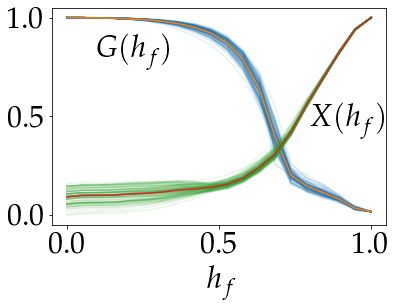

In [414]:
plt.plot(np.linspace(0,1,20),a1.data['sigmaGS'].T,alpha=.1,c='C0',label='GS');
plt.plot(np.linspace(0,1,20),np.average(a1.data['sigmaGS'],axis=0),c='C1');
plt.plot(np.linspace(0,1,20),a1.data['sigmax'].T,alpha=.1,c='C2');
plt.plot(np.linspace(0,1,20),np.average(a1.data['sigmax'],axis=0),c='C3');
plt.xlabel('$h_f$')
#plt.ylabel('DQPT-OP')
plt.text(.1,.8,'$G(h_f)$')
plt.text(.8,.45,'$X(h_f)$')
plt.savefig('figures/quench.png',dpi=300,bbox_inches='tight')

In [273]:
rsGS = np.zeros(len(Ns))
rsx = np.zeros(len(Ns))
for iN,N in enumerate(Ns):
    a1 = analyze_gap_DQPT_anneal(N)
    a1.checkForData()
    a1.load()
    rsGS[iN] = pearsonr(a1.multReg(a1.data['sigmaGS']),a1.data['minGap'])[0]
    rsx[iN] = pearsonr(a1.multReg(a1.data['sigmax']),a1.data['minGap'])[0]

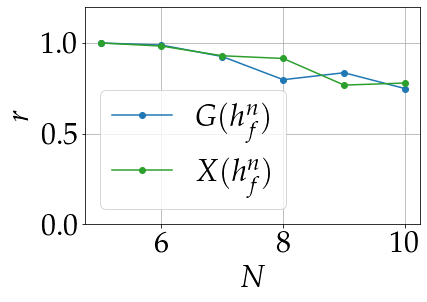

In [274]:
plt.plot(Ns,rsGS,'o-',label='$G(h_f^n)$')
plt.plot(Ns,rsx,'C2o-',label='$X(h_f^n)$')
plt.legend()
plt.ylim(0,1.2)
plt.grid()
plt.xlabel('$N$')
plt.ylabel('$r$')
plt.savefig('figures/pearsonr.png',dpi=300,bbox_inches='tight')

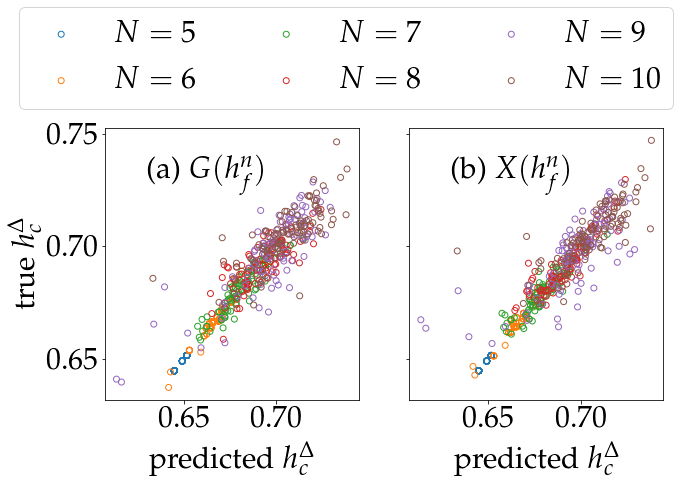

In [287]:
fig, axs = plt.subplots(ncols=2,figsize=(10,5),sharey=True)
for iN,N in enumerate(Ns):
    a1 = analyze_gap_DQPT_anneal(N)
    a1.checkForData()
    a1.load()
    axs[0].scatter(a1.data['minGap'],a1.multReg(a1.data['sigmaGS']),\
                color='C'+str(iN),marker='o',facecolor='none',label=f'$N={N}$')
    axs[1].scatter(a1.data['minGap'],a1.multReg(a1.data['sigmax']),\
                color='C'+str(iN),marker='o',facecolor='none',label=f'$N={N}$')
plt.legend(bbox_to_anchor=(1.1,1.5),ncol=3)
axs[0].set_xlabel('predicted $h_c^\Delta$')
axs[1].set_xlabel('predicted $h_c^\Delta$ ')
axs[0].set_ylabel('true $h_c^\Delta$')
axs[0].text( .63,.73,'(a) $G(h^n_f)$')
axs[1].text( .63,.73,'(b) $X(h^n_f)$')
plt.savefig('figures/predictMinGap.png',dpi=300,bbox_inches='tight')

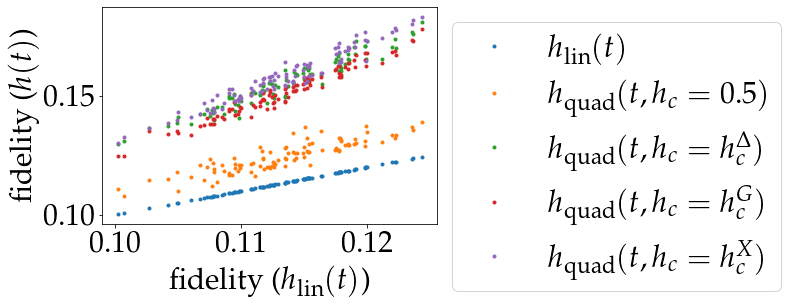

In [291]:
a1.plot_corr('fidelity_lin','fidelity_lin',label=r'$h_\mathrm{lin}(t)$')
a1.plot_corr('fidelity_lin','fidelity_quad1_2',label=r'$h_\mathrm{quad}(t,h_c=0.5)$')
a1.plot_corr('fidelity_lin','fidelity_quad_minGap',label=r'$h_\mathrm{quad}(t,h_c=h_c^\Delta)$')
a1.plot_corr('fidelity_lin','fidelity_quad_sigmaGS',label=r'$h_\mathrm{quad}(t,h_c=h_c^G)$')
a1.plot_corr('fidelity_lin','fidelity_quad_sigmax',label=r'$h_\mathrm{quad}(t,h_c=h_c^X)$')
plt.xlabel('fidelity ($h_\mathrm{lin}(t)$)')
plt.ylabel('fidelity ($h(t)$)')
plt.legend(bbox_to_anchor=(1,1))
#plt.title('$N_=$'+str(N))
plt.savefig('figures/fidelity_N10.png',dpi=300,bbox_inches='tight')

In [10]:
anneal_labels = [r'$h_\mathrm{lin}(t)$',r'$h_\mathrm{quad}(t,h_c=0.5)$',r'$h_\mathrm{quad}(t,h_c=h_c^\Delta)$',
                 r'$h_\mathrm{quad}(t,h_c=h_c^G)$',r'$h_\mathrm{quad}(t,h_c=h_c^X)$']
Tann_markers = ['o-','s-','^-','v-','*-']

In [11]:
Ns = np.arange(5,11)
Tanns = [1,1.5,2,2.5,3]
scaling_Tann = np.zeros((len(Tanns),5,len(Ns)))
for iTann,Tann in enumerate(Tanns):
    for iN,N in enumerate(Ns):
        a_ = analyze_gap_DQPT_anneal(N,Tann=Tann)
        a_.checkForData()
        if a_.isComputed:
            a_.load()

            scaling_Tann[iTann,:,iN] = [np.average(a_.data['fidelity_lin']), \
            np.average(a_.data['fidelity_quad1_2']), \
            np.average(a_.data['fidelity_quad_minGap']), \
            np.average(a_.data['fidelity_quad_sigmaGS']), \
            np.average(a_.data['fidelity_quad_sigmax'])]

        else:
            scaling_Tann[iTann,:,iN] = np.nan

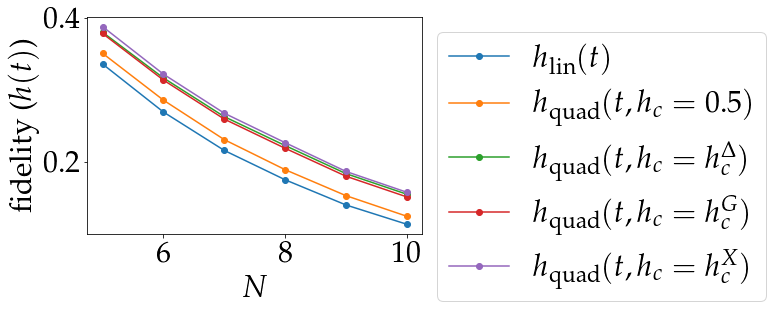

In [292]:

for iTann,Tann in enumerate([1]):
    plt.gca().set_prop_cycle(None)
    for i,label in enumerate(anneal_labels):
        plt.plot(Ns,scaling_Tann[iTann,i],Tann_markers[iTann],label=label)

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('$N$')
plt.ylabel('fidelity ($h(t)$)')
plt.savefig('figures/fidelityScaling.png',dpi=300,bbox_inches='tight')

In [41]:
from scipy.optimize import curve_fit

In [42]:
def f_lin(x, a, b):
    return a * x + b

/home/birsigler/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/birsigler/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(1.0, 3.0)

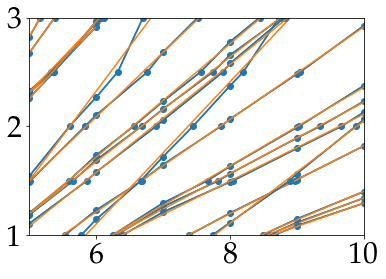

In [413]:

prefacs = np.zeros((5, 4))
for j in range(5):
    CS=plt.contour(Ns,Tanns,scaling_Tann[:,j],colors='C0',levels=[.2,.3,.4,.5])
    for i in range(4):
        temp = CS.collections[i].get_segments()[0]
        plt.plot(temp[:, 0], temp[:, 1], 'C0o-')
        temp = curve_fit(f_lin, temp[:, 0], temp[:, 1])[0]
        x = np.linspace(5, 10)
        plt.plot(x, f_lin(x, temp[0], temp[1]), 'C1-')
        prefacs[j, i] = temp[0]
plt.ylim(1, 3)

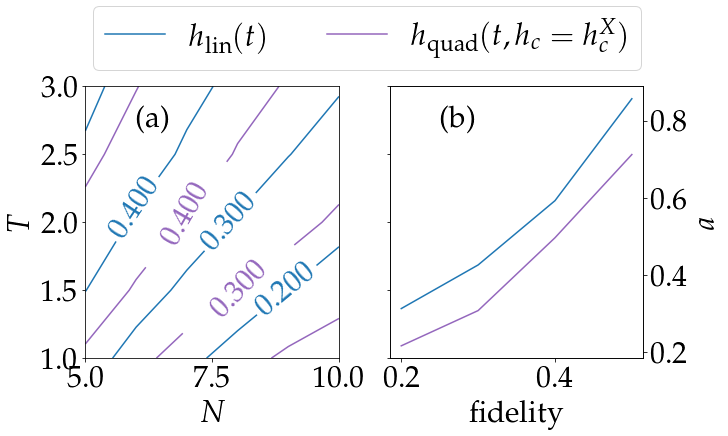

In [371]:
fig, axs = plt.subplots(ncols = 2, figsize = (10, 5), sharey = True)


CS=axs[0].contour(Ns,Tanns,scaling_Tann[:,0],colors='C0',levels=[.2,.3,.4,.5])
axs[0].plot([0],[0],'C0')
axs[0].clabel(CS, inline=True, fontsize=30)
CS=axs[0].contour(Ns,Tanns,scaling_Tann[:,4],colors='C4',levels=[.2,.3,.4,.5])
axs[0].plot([0],[0],'C4')

axs[0].clabel(CS, inline=True, fontsize=30)

axs[0].set_xlim(Ns.min(),Ns.max())
axs[0].set_ylim(np.min(Tanns),np.max(Tanns))
axs[0].set_xlabel('$N$')
axs[0].set_ylabel('$T$')

ax = axs[1].twinx()
ax.plot([.2,.3,.4,.5], prefacs[0],label=anneal_labels[0])
ax.plot([.2,.3,.4,.5], prefacs[4], 'C4',label=anneal_labels[4])
ax.set_ylabel('$a$')
axs[1].set_xlabel('fidelity')
ax.legend(bbox_to_anchor=(1.05, 1.35), ncol = 2)

axs[0].text(6, 2.7, '(a)')
axs[1].text(.25, 2.7, '(b)')

#fig.tight_layout()
plt.savefig('figures/scaling.png',dpi=300,bbox_inches='tight')

In [1562]:
#master
def gap_DQPT(Nspin,Ninstance,Nh):
    #hyperparameters
    hs = np.linspace(0,1,Nh)
    Tsig, Nsig = 20, 100
    times = np.linspace(0, Tsig, Nsig)
    
    hamiltonian = np.zeros((Ninstance,2**Nspin))
    Gap = np.zeros((Ninstance,Nh))
    sigmaGS = np.zeros((Ninstance,Nh))
    sigmax = np.zeros((Ninstance,Nh))
    
    basis=spin_basis_general(Nspin)
    
    for i in range(Ninstance):
        print(i,end='\r')
        
        #hamiltonian
        H = USA_hamiltonian(basis)
        hamiltonian[i] = H.diagonal()
        
        #minGap
        try:
            f_Delta = lambda x: gap_sparse(basis,H,x)
            Gs = np.zeros(len(hs))
            for j,h in enumerate(hs):
                Gs[j] = f_Delta(h)
            Gap[i] = Gs
        except:
            f_Delta = lambda x: gap(basis,H,x)
            Gs = np.zeros(len(hs))
            for j,h in enumerate(hs):
                Gs[j] = f_Delta(h)
            Gap[i] = Gs
    
        #DQPT GS
        GSs = np.zeros(Nh)
        xs = np.zeros(Nh)
        for j,h in enumerate(hs):
            GSs[j] = DQPT_OP(basis,H,h,times,'GS')
            xs[j] = DQPT_OP(basis,H,h,times,'x')
        sigmaGS[i] = GSs
        sigmax[i] = xs

        
    np.savez('gap_DQPT_data_Nspin{}_Nh{}_Tsig{}_Nsig{}.npz'.format(Nspin,Nh,Tsig,Nsig), \
             Gap = Gap, \
             sigmaGS = sigmaGS, \
             sigmax = sigmax)


In [301]:
exam = np.load('gap_DQPT_anneal_data_Nspin7_Nh20_Tsig20_Nsig100_Tann1_Nann100.npz')

In [302]:
abs(exam['fidelity_lin']-np.average(exam['fidelity_lin'])).argmin()

17

In [304]:
def ham_from_diag(H):
    return hamiltonian([np.diag(H)],[],dtype=np.float64)

In [305]:
H_ = ham_from_diag(exam['hamiltonian'][17])

In [306]:
exam['hamiltonian'][17]

array([24., 16., 12., 12., 16., 16.,  4., 12., 20., 12.,  8.,  8., 20.,
       20.,  8., 16.,  8.,  8., 20., 28.,  0.,  8., 12., 28.,  4.,  4.,
       16., 24.,  4., 12., 16., 32.,  8.,  8.,  4., 12., 16., 24., 12.,
       28., 12., 12.,  8., 16., 28., 36., 24., 40.,  8., 16., 28., 44.,
       16., 32., 36., 60., 12., 20., 32., 48., 28., 44., 48., 72., 16.,
        8., 12., 12.,  8.,  8.,  4., 12., 12.,  4.,  8.,  8., 12., 12.,
        8., 16., 16., 16., 36., 44.,  8., 16., 28., 44., 12., 12., 32.,
       40., 12., 20., 32., 48.,  8.,  8., 12., 20., 16., 24., 20., 36.,
       12., 12., 16., 24., 28., 36., 32., 48., 24., 32., 52., 68., 32.,
       48., 60., 84., 28., 36., 56., 72., 44., 60., 72., 96.])

In [307]:
basis_ = spin_basis_general(7)

In [308]:
lin_anneal(basis_,H_,1,7,plot=True)[1][-1]

NameError: name 'lin_anneal' is not defined

In [309]:
Gaps = np.zeros(1000)
hs = np.linspace(0,1,len(Gaps))
for i in range(len(Gaps)):
    Gaps[i] = gapJ(basis_,H_,hs[i])

In [310]:
test1 = fullGap_protocol(basis_,H_,Gaps,1,0,plot=False)

In [312]:

test2 = fullGap_protocol(basis_,H_,Gaps,1,3./2,plot=False)
test3 = fullGap_protocol(basis_,H_,Gaps,1,2,plot=False)
test4 = fullGap_protocol(basis_,H_,Gaps,1,10,plot=False)

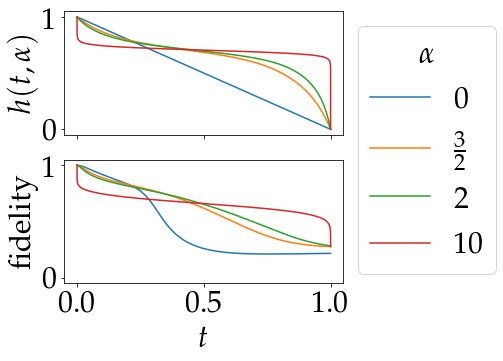

In [317]:
fig, axs = plt.subplots(nrows=2,sharex=True,sharey=True,figsize=(5,5))
axs[0].plot(test1[0],test1[2],'-',label=r'$0$')
axs[0].plot(test2[0],test2[2],'-',label=r'$\frac{3}{2}$')
axs[0].plot(test3[0],test3[2],'-',label=r'$2$')
axs[0].plot(test4[0],test4[2],'-',label=r'$10$')

axs[1].plot(test1[0],test1[1],'-',label=r'$0$')
axs[1].plot(test2[0],test2[1],'-',label=r'$\frac{3}{2}$')
axs[1].plot(test3[0],test3[1],'-',label=r'$2$')
axs[1].plot(test4[0],test4[1],'-',label=r'$10$')

axs[1].set_xlabel('$t$')
axs[0].set_ylabel(r'$h(t,\alpha)$')
axs[1].set_ylabel(r'fidelity')
axs[0].legend(bbox_to_anchor=(1.,1),ncol=1,title=r"$\alpha$")
plt.savefig('figures/fidVst.png',dpi=300,bbox_inches='tight')

In [323]:
alphas = np.arange(0, 10.5, .5)
F_T = np.zeros(len(alphas))
F_T_ = np.zeros(len(alphas))
for i in range(len(alphas)):
    temp = fullGap_protocol(basis_,H_,Gaps,1,alphas[i],plot=False)
    F_T[i], F_T_[i] = temp[1][-1], temp[1][-2]

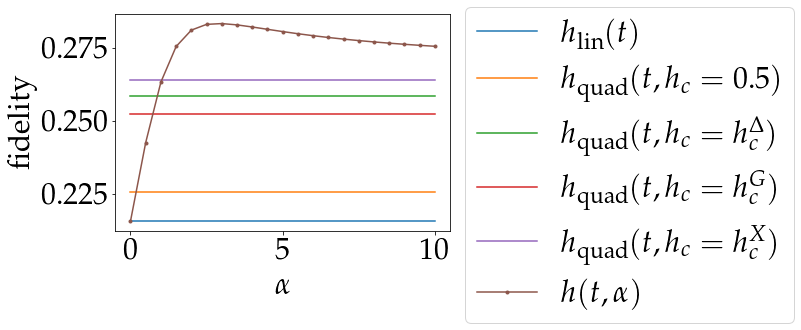

In [324]:

plt.plot([0,10],exam['fidelity_lin'][17]*np.ones(2),label=anneal_labels[0])
plt.plot([0,10],exam['fidelity_quad1_2'][17]*np.ones(2),label=anneal_labels[1])
plt.plot([0,10],exam['fidelity_quad_minGap'][17]*np.ones(2),label=anneal_labels[2])
plt.plot([0,10],exam['fidelity_quad_sigmaGS'][17]*np.ones(2),label=anneal_labels[3])
plt.plot([0,10],exam['fidelity_quad_sigmax'][17]*np.ones(2),label=anneal_labels[4])
plt.plot(alphas,F_T,'.-',label=r'$h(t,\alpha)$')
plt.ylabel('fidelity')
plt.xlabel(r'$\alpha$')
plt.legend(bbox_to_anchor=(1,1.1))
plt.savefig('figures/fidVsAlpha.png',dpi=300,bbox_inches='tight')

In [327]:
alphas = np.arange(1.5, 11, .5)

In [162]:
def fid_alpha(inst, alphas):
    def ham_from_diag(H):
        return hamiltonian([np.diag(H)],[],dtype=np.float64)
    H_ = ham_from_diag(inst)
    basis_ = spin_basis_general(7)
    Gaps = np.zeros(1000)
    hs = np.linspace(0,1,len(Gaps))
    for i in range(len(Gaps)):
        Gaps[i] = gapJ(basis_,H_,hs[i])
    
    F_T = np.zeros(len(alphas))
    F_T_ = np.zeros(len(alphas))
    for i in range(len(alphas)):
        temp = fullGap_protocol(basis_,H_,Gaps,1,alphas[i],plot=False)
        F_T[i], F_T_[i] = temp[1][-1], temp[1][-2]
    return F_T

In [163]:
fids_alpha = np.zeros((exam['hamiltonian'].shape[0], len(alphas)))

In [164]:
for i in range(fids_alpha.shape[0]):
    print(i, end = '\r')
    fids_alpha[i] = fid_alpha(exam['hamiltonian'][i], alphas)

In [165]:
#np.save('fids_alpha2.npy', fids_alpha)

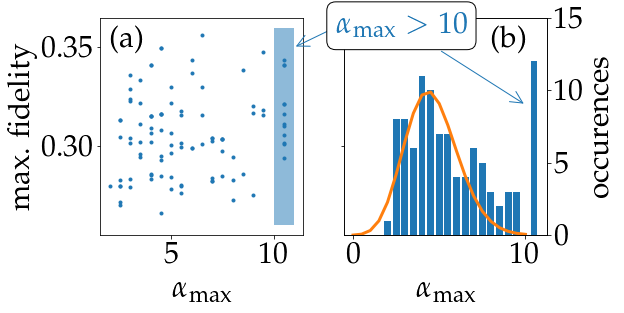

In [410]:
fig, axs = plt.subplots(ncols = 2, figsize = (8, 4), sharey = True)
axs[0].plot(list(map(lambda x: alphas[x], np.argmax(fids_alpha, axis = 1))), np.max(fids_alpha, axis = 1), '.')
axs[0].set_xlabel(r'$\alpha_\mathrm{max}$')
axs[0].set_ylabel('max. fidelity')
axs[0].fill_between([10, 11], .26, .36, facecolor='C0', alpha=0.5)
axs[0].text(2, .35, '(a)')
axs[1].text(8, .35, '(b)')

ax = axs[1].twinx()
ax.set_ylim(0, 15)
ax.bar(alphas, hist_lst, width = .4)
ax.set_ylabel('occurences')
axs[1].set_xlabel(r'$\alpha_\mathrm{max}$')
ax.annotate(r'$\alpha_\mathrm{max}>10$', xy=(10, 9), xytext=(-1, 14), 
    arrowprops=dict(arrowstyle="->", color = 'C0'), c = 'C0', 
    bbox=dict(boxstyle="round", fc="w"))

ax.plot(np.arange(0, 10.5, .5) , f_poi(np.arange(21), 9.19294608, 75.10916785), 'C1', lw = 3)

axs[0].annotate(r'', xy=(11, .35), xytext=(13, .36), arrowprops=dict(arrowstyle="->", color = 'C0'))
plt.savefig('figures/alpha_stat.png',dpi=300,bbox_inches='tight')

In [199]:
hist_lst = []
for i in range(len(alphas)):
    hist_lst += [np.sum(np.argmax(fids_alpha, axis = 1) == i)]
hist_lst = np.array(hist_lst)

In [383]:
from math import exp, factorial
def poisson(k, lam):
    return lam ** k * exp(-lam) / np.vectorize(factorial)(k)

In [385]:
def f_poi(x, a, b):
    return b * np.vectorize(poisson)(x, a)

In [387]:
f_poi((2*alphas).astype(int), 1, 1)

array([6.13132402e-02, 1.53283100e-02, 3.06566201e-03, 5.10943668e-04,
       7.29919526e-05, 9.12399408e-06, 1.01377712e-06, 1.01377712e-07,
       9.21615563e-09, 7.68012969e-10, 5.90779207e-11, 4.21985148e-12,
       2.81323432e-13, 1.75827145e-14, 1.03427732e-15, 5.74598513e-17,
       3.02420270e-18, 1.51210135e-19, 7.20048262e-21])

In [401]:
curve_fit(f_poi, (2*alphas).astype(int)[:-1], hist_lst[:-1], p0 = [1, 100])

(array([ 9.19297756, 75.10923266]),
 array([[ 0.17327488,  0.35700275],
        [ 0.35700275, 53.8151637 ]]))

In [99]:
def fullGap_protocol(basis,H,gaps,T,alpha,plot=True):
    
    N_steps = gaps.shape[0]
    hs = np.linspace(0,1,N_steps)
    C = T/np.sum(gaps[::-1]**-alpha)
    Delta_t = C*gaps[::-1]**-alpha
    times = np.cumsum(Delta_t)
    
    if plot:
        plt.plot(times,hs[::-1],'.-')
        plt.plot(times,gaps[::-1]/4,'--')
        plt.xlabel('$t$')
        plt.ylabel('$h(t)$')
    
    x_field=[[-1,j] for j in range(basis.N)]
    static=[["x",x_field]]
    H1 =  hamiltonian(static,[],basis=basis,dtype=np.float64,check_symm=False, check_herm=False)
    E1, V1, = H1.eigh()
    psi = V1[:,0]
    
    time_evolved = np.zeros((2**basis.N,N_steps),complex)
    instantaneous = np.zeros((2**basis.N,N_steps),complex)
    
    for i in range(N_steps):
        h = hs[::-1][i]
        #instantaneous
        x_field=[[-h,j] for j in range(basis.N)]
        static=[(1-h)*H.static,["x",x_field]]
        H2 =  hamiltonian(static,[],basis=basis,dtype=np.float64,check_symm=False, check_herm=False)
        E2, V2 = H2.eigh()
        #plt.plot(i,h,'o')
        instantaneous[:,i] = V2[:,0]
        
        #evolved
        time_evolved[:,i] = psi
        psi = ED_state_vs_time(psi,E2,V2,[Delta_t[i]])[:,-1]
            
    overlap = abs(np.dot(time_evolved.T.conj(),instantaneous)).diagonal()
    
    return times, overlap, hs[::-1]
